In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
! cp -r /content/drive/MyDrive/ML_PROJECTS/Classification/Titanic_Survival_Prediction/titanic.zip /content

In [3]:
!unzip /content/titanic.zip

Archive:  /content/titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [4]:
train_df = pd.read_csv('/content/train.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [6]:
train_df.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [7]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Feature Engineering

1 = survived
0 = didn't survive


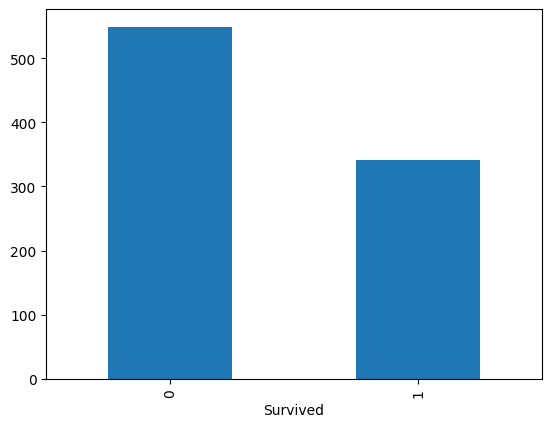

In [8]:
train_df['Survived'].value_counts().plot.bar()
print("1 = survived\n0 = didn't survive")

<Axes: xlabel='Sex'>

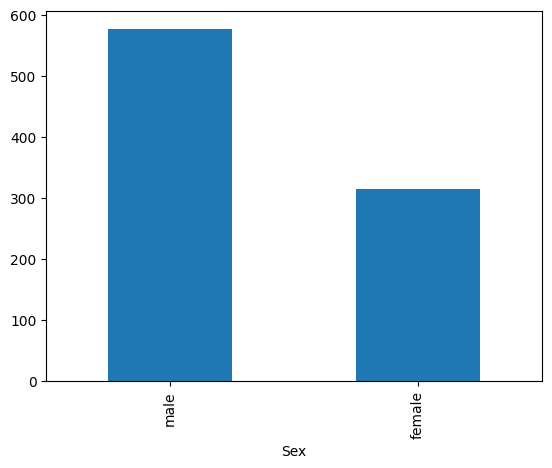

In [9]:
train_df['Sex'].value_counts().plot.bar()

In [10]:
# passenger details
train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
train_df['Title'] = train_df['Title'].replace(['Mlle','Ms'],'Miss')
train_df['Title'] = train_df['Title'].replace(['Mme'],'Mrs')
train_df.sample(5)

<>:2: SyntaxWarning: invalid escape sequence '\.'
<>:2: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-1458073838.py:2: SyntaxWarning: invalid escape sequence '\.'
  train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
646,647,0,3,"Cor, Mr. Liudevit",male,19.0,0,0,349231,7.8958,NaN,S,Mr
489,490,1,3,"Coutts, Master. Eden Leslie ""Neville""",male,9.0,1,1,C.A. 37671,15.9000,NaN,S,Master
577,578,1,1,"Silvey, Mrs. William Baird (Alice Munger)",female,39.0,1,0,13507,55.9000,E44,S,Mrs
558,559,1,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",female,39.0,1,1,110413,79.6500,E67,S,Mrs
670,671,1,2,"Brown, Mrs. Thomas William Solomon (Elizabeth ...",female,40.0,1,1,29750,39.0000,NaN,S,Mrs


In [11]:
## Number of family members
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
train_df['IsAlone'] = (train_df['FamilySize'] == 1).astype(int)
train_df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,IsAlone
79,80,1,3,"Dowdell, Miss. Elizabeth",female,30.0,0,0,364516,12.4750,NaN,S,Miss,1,1
660,661,1,1,"Frauenthal, Dr. Henry William",male,50.0,2,0,PC 17611,133.6500,NaN,S,Dr,3,0
818,819,0,3,"Holm, Mr. John Fredrik Alexander",male,43.0,0,0,C 7075,6.4500,NaN,S,Mr,1,1
103,104,0,3,"Johansson, Mr. Gustaf Joel",male,33.0,0,0,7540,8.6542,NaN,S,Mr,1,1
47,48,1,3,"O'Driscoll, Miss. Bridget",female,NaN,0,0,14311,7.7500,NaN,Q,Miss,1,1


In [12]:
## Cabin Info
train_df['Deck'] = train_df['Cabin'].astype(str).str[0]
train_df['Deck'] = train_df['Deck'].replace('n','Missing')
train_df['HasCabin'] = train_df['Cabin'].notnull().astype(int)
print(f"{train_df['Deck'].sample(5)}\n{train_df['HasCabin'].sample(5)}")

653    Missing
299          B
458    Missing
775    Missing
274    Missing
Name: Deck, dtype: object
538    0
291    1
696    0
677    0
860    0
Name: HasCabin, dtype: int64


In [13]:
# Age Grouping
train_df['Age'] = train_df['Age'].fillna(train_df.groupby(['Title','Pclass'])['Age'].transform('median'))
train_df['AgeBin'] = pd.cut(train_df['Age'], bins=[0,12,20,40,60,80], labels=False)

In [14]:
train_df.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,IsAlone,Deck,HasCabin,AgeBin
872,873,0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0000,B51 B53 B55,S,Mr,1,1,B,1,2
216,217,1,3,"Honkanen, Miss. Eliina",female,27.0,0,0,STON/O2. 3101283,7.9250,NaN,S,Miss,1,1,Missing,0,2
291,292,1,1,"Bishop, Mrs. Dickinson H (Helen Walton)",female,19.0,1,0,11967,91.0792,B49,C,Mrs,2,0,B,1,1
744,745,1,3,"Stranden, Mr. Juho",male,31.0,0,0,STON/O 2. 3101288,7.9250,NaN,S,Mr,1,1,Missing,0,2
371,372,0,3,"Wiklund, Mr. Jakob Alfred",male,18.0,1,0,3101267,6.4958,NaN,S,Mr,2,0,Missing,0,1


In [15]:
train_df.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


In [16]:
## since name is not going to play role in the survival rate, we remove that from our df.
## PassengerID either have no relationship with survival
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
train_df.sample()

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize,IsAlone,Deck,HasCabin,AgeBin
372,0,3,male,19.0,0,0,323951,8.05,NaN,S,Mr,1,1,Missing,0,1


In [17]:
train_df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked', 'Title', 'FamilySize', 'IsAlone', 'Deck',
       'HasCabin', 'AgeBin'],
      dtype='object')

In [18]:
train_df.dtypes

,0
Survived,int64
Pclass,int64
Sex,object
Age,float64
SibSp,int64
Parch,int64
Ticket,object
Fare,float64
Cabin,object
Embarked,object


## Preprocessing our data

In [19]:
cat_features = ['Sex', 'Cabin', 'Embarked']
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

num_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, cat_features),
        ('num', num_transformer, num_features)
    ]
)

## Spliting data into feature and label

In [20]:
x = train_df.drop('Survived', axis=1)
y = train_df['Survived']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=42)

In [29]:
## RandomForestClassifier
model1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

model1.fit(x_train, y_train)
score1 = model1.score(x_test, y_test)
score1

0.8379888268156425

In [30]:
## XGBClassifier
model2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42))
])
model2.fit(x_train, y_train)
score2 = model2.score(x_test, y_test)
score2

0.8324022346368715

In [31]:
## GradientBoostingClassifier
model3 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])
model3.fit(x_train, y_train)
score3 = model3.score(x_test, y_test)
score3

0.8044692737430168

## Comparision between the models

/tmp/ipython-input-2670510416.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')


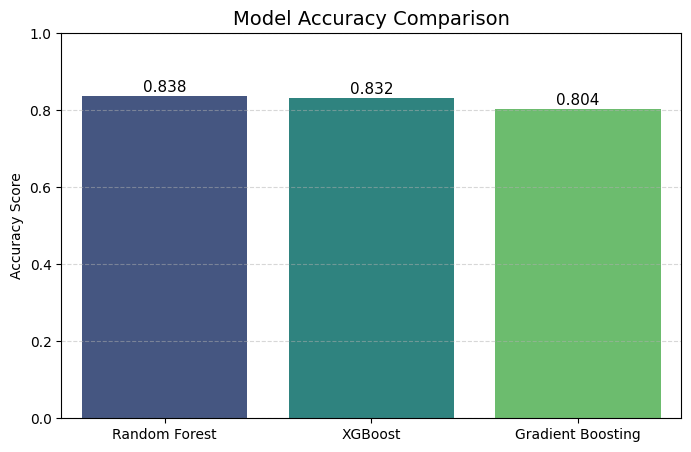

In [33]:
results = {
    'Random Forest': score1,
    'XGBoost': score2,
    'Gradient Boosting': score3
}

# make simple bar chart
plt.figure(figsize=(8,5))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')

plt.title('Model Accuracy Comparison', fontsize=14)
plt.ylabel('Accuracy Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# show score on top of bars
for i, v in enumerate(results.values()):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', fontsize=11)

plt.show()

In [36]:
## Grid Search CV
param_grid = {
    "preprocessor__num__imputer__strategy": ['mean', 'median'],
    "classifier__n_estimators": [100, 400, 1000],
    "classifier__max_depth": [3, 5, 7],
    "classifier__min_samples_split": [2, 4],
    "classifier__min_samples_leaf": [2, 3]
}
gs_model1 = GridSearchCV(
    estimator=model1,
    param_grid=param_grid,
    cv=5,
    verbose=3
)

gs_model1.fit(x_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5] END classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=100, preprocessor__num__imputer__strategy=mean;, score=0.804 total time=   0.2s
[CV 2/5] END classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=100, preprocessor__num__imputer__strategy=mean;, score=0.818 total time=   0.2s
[CV 3/5] END classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=100, preprocessor__num__imputer__strategy=mean;, score=0.810 total time=   0.2s
[CV 4/5] END classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__min_samples_split=2, classifier__n_estimators=100, preprocessor__num__imputer__strategy=mean;, score=0.761 total time=   0.2s
[CV 5/5] END classifier__max_depth=3, classifier__min_samples_leaf=2, classifier__min_samples_split=2, cla

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['Sex',
                                                                          'Cabin',
                                                                          'Embarked']),
                                                                        ('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Pclass',
                                                                          'Age',
                                                                          'SibSp',
                                                                          'Parch',
                                                                          'Fare'])])),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'classifier__max_depth': [3, 5, 7],
                         'classifier__min_samples_leaf': [2, 3],
                         'classifier__min_samples_split': [2, 4],
                         'classifier__n_estimators': [100, 400, 1000],
                         'preprocessor__num__imputer__strategy': ['mean',
                                                                  'median']},
             verbose=3)

In [37]:
gs_model1.score(x_test, y_test)

0.8044692737430168

In [38]:
gs_model1.best_params_

{'classifier__max_depth': 7,
 'classifier__min_samples_leaf': 2,
 'classifier__min_samples_split': 2,
 'classifier__n_estimators': 1000,
 'preprocessor__num__imputer__strategy': 'mean'}

In [39]:
test_df = pd.read_csv('/content/test.csv')
passenger_ids = test_df['PassengerId'].copy()
passenger_ids

,PassengerId
0,892
1,893
2,894
3,895
4,896
...,...
413,1305
414,1306
415,1307
416,1308


In [40]:
result = gs_model1.predict(test_df)

In [41]:
output = pd.DataFrame({"PassengerId":passenger_ids,"Survived":result})
output.to_csv("/content/drive/MyDrive/ML_PROJECTS/Classification/Titanic_Survival_Prediction/submission.csv",index=False)

<Axes: xlabel='Survived'>

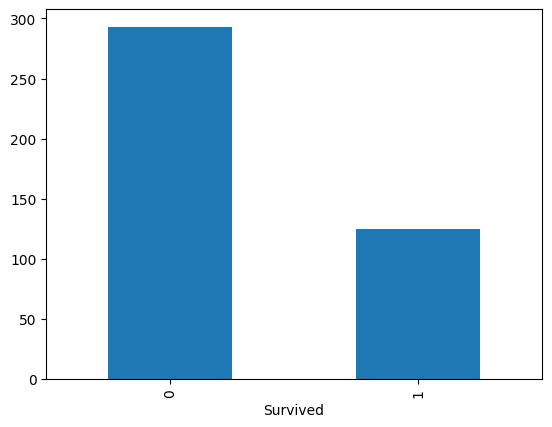

In [42]:
df=pd.read_csv('/content/drive/MyDrive/ML_PROJECTS/Classification/Titanic_Survival_Prediction/submission.csv')
df['Survived'].value_counts().plot.bar()

<Axes: xlabel='Survived'>

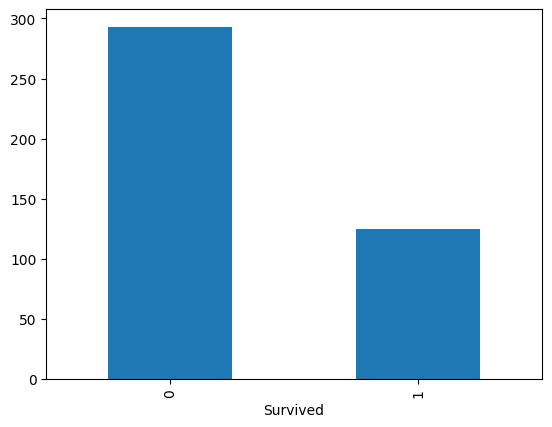

In [43]:
result = model1.predict(test_df)
output = pd.DataFrame({"PassengerId":passenger_ids,"Survived":result})
output.to_csv("/content/drive/MyDrive/ML_PROJECTS/Classification/Titanic_Survival_Prediction/submission1.csv",index=False)


<Axes: xlabel='Survived'>

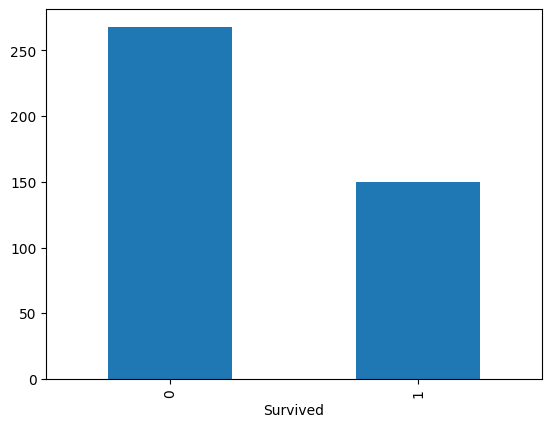

In [44]:
df=pd.read_csv('/content/drive/MyDrive/ML_PROJECTS/Classification/Titanic_Survival_Prediction/submission1.csv')
df['Survived'].value_counts().plot.bar()